In [1]:
import h5py
import matplotlib.pyplot as plt
from measureia import MeasureIABox
from measureia import ReadData

# MeasureIA usage 
MeasureIA can be used to measure intrinsic alignment correlation functions and clustering in hydrodynamic simulations. 
Both the w_gg, w_g+ and multipole moment estimators can be measured.

## Parameters for MeasureIA object
These are the parameters we need to enter to create the MeasureIA object. They govern measurement parameters, e.g. r(p) and pi bins (bounds, number of bins...).

In [14]:
simulation = "TNG300"  # Indicator of simulation.
# Choose from [TNG100, TNG100_2, TNG300, EAGLE, HorizonAGN, FLAMINGO_L1, FLAMINGO_L2p8] for now.
# If your simulation is not included: input None and make sure to add the boxsize input parameter in the object creation.
# If this is used, the boxsize is in Mpc/h so the positions and r/rp limits must also be in these units.
snapshot = 99  # Number of snapshot - for saving the output in group 'Snapshot_99'
outfile = f'../tests/data/processed/TNG300/example_IA.hdf5'  # file path to output data and datafile name (must be hdf5)
num_nodes = 3  # number of CPU cores available for calculation
r_lims = [0.1, 20.]  # r or rp bin edges. Must be in same units as position and boxsize.
num_r = 10  # number of r or rp bins
num_pi = 8  # number of pi bins. (trivial for wg+, not too little for multipoles)
pimax = None  # pi max value, if None, half the boxsize is used.
periodicity = True  # take periodic boundary conditions into account

## Parameters for methods
These are the parameters that are needed to configure the methods that are called. 
They govern what is measured and which methods are used. Check the method docstrings for extensive explanations.

In [15]:
tree_path = f"./"  # path where tree can be temporarily stored. For large samples this file can grow large.
# If tree_path=None, no trees will be used (slower calculation)
measure_cov = True  # If true, jackknife errors are calculated (Default is True)
num_jk = 27  # number of jackknife regions. Must be x^3 with x and int.
corr_type = "both"  # type of correlation to be calculated, choose g+, gg or both
remove_tree_file = True  # if True (default), tree file is removed at the end of the calculation.
masks = None  # optional directory in form of data_dir containing masks to be placed over data in data_dir
rp_cut = None  # optional minimum cut on rp for multipoles calculation

## Create data dictionary
The data input is managed via a dictionary. These need to have specific keys (see below) and contain the position coordinates of both samples, eigen vectors of the chosen axis (shape) and the ratio of the projected axis lengths.

In [16]:
data_file = h5py.File('../tests/data/raw/TNG300/mock_TNG300_large.hdf5', 'a')
COM = data_file["COM"][:]
Semimajor_Axis_Direction = data_file["Semimajor_Axis_Direction"][:]
q = data_file["q"][:]
data_file.close()

data_dir = {
	"Position": COM,  # positions of the position (D) sample
	"Position_shape_sample": COM,  # positions of the shape (S) sample
	"Axis_Direction": Semimajor_Axis_Direction,
	"LOS": 2,  # column index of the line of sight parameter (2 assumes the shapes are projected over the z-axis)
	"q": q,
}

## Run
Providing a dataset name and all parameters defined above, the runs for wgg, wg+ and the multipoles are called bellow.

In [17]:
dataset_name = "test"

MeasureIA_test = MeasureIABox(data_dir, simulation=simulation, snapshot=snapshot,
								 separation_limits=r_lims, pi_max=pimax,
								 num_bins_r=num_r, num_nodes=num_nodes,
								 num_bins_pi=num_pi, output_file_name=outfile, periodicity=periodicity)
# measure wgg, wg+
MeasureIA_test.measure_xi_w(dataset_name, corr_type, num_jk, file_tree_path=tree_path)
# measure multipoles
MeasureIA_test.measure_xi_multipoles(dataset_name, corr_type, num_jk, file_tree_path=tree_path)

MeasureIA object initialised with:
 			simulation TNG300 that has a periodic boxsize of 205.0 cMpc/h.
 			There are 4547 galaxies in the shape sample and 4547 galaxies in the position sample.
			The separation bin edges are given by [ 0.1         0.16986465  0.28853998  0.49012742  0.83255321  1.41421356
  2.40224887  4.08057155  6.93144843 11.77408037 20.        ] cMpc/h.
 			There are 10 r or r_p bins and 8 pi bins.
 			The maximum pi used for binning is 102.5.
 			The data will be written to ../tests/data/processed/TNG300/example_IA.hdf5
There are 4547 galaxies in the shape sample and 4547 galaxies in the position sample.
There are 4547 galaxies in the shape sample and 4547 galaxies in the position sample.


## Read data
There is an internal read class that reads the output file. 
It provides two ways of reading the data. One, is using the read_MeasureIA_output method, and the second is using the read_cat method. Both are shown below.
You can also read the output file manually, using the described output file structure in the README

In [18]:
# version 1
IA_data = ReadData(simulation,"example_IA",99,data_path="../tests/data/processed/TNG300/")
IA_data.read_MeasureIA_output("test",27)

# version 2
IA_data_wgg = ReadData(simulation,"example_IA",99,sub_group="w_gg/",data_path="../tests/data/processed/TNG300/")
wgg = IA_data_wgg.read_cat("test")
rp = IA_data_wgg.read_cat("test_rp")
wgg_error = IA_data_wgg.read_cat("test_jackknife_27")

IA_data_wgp = ReadData(simulation,"example_IA",99,sub_group="w_g_plus/",data_path="../tests/data/processed/TNG300/")
wgp = IA_data_wgp.read_cat("test")
rp = IA_data_wgp.read_cat("test_rp")
wgp_error = IA_data_wgp.read_cat("test_jackknife_27")

## Plot w_gg

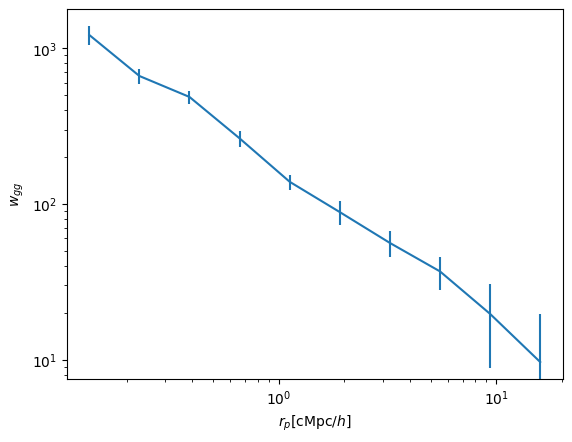

In [19]:
plt.figure()
plt.errorbar(IA_data.rp,IA_data.w_gg,yerr=IA_data.errors_w_gg)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$w_{gg}$")
plt.xlabel(r"$r_p [\mathrm{cMpc}/h]$")
plt.show()

## Plot w_g+

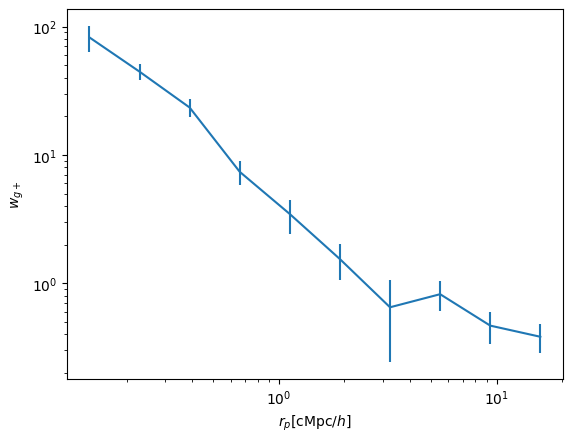

In [20]:
plt.figure()
plt.errorbar(IA_data.rp,IA_data.w_gp,yerr=IA_data.errors_w_gp)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$w_{g+}$")
plt.xlabel(r"$r_p [\mathrm{cMpc}/h]$")
plt.show()

## Plot multipoles clustering

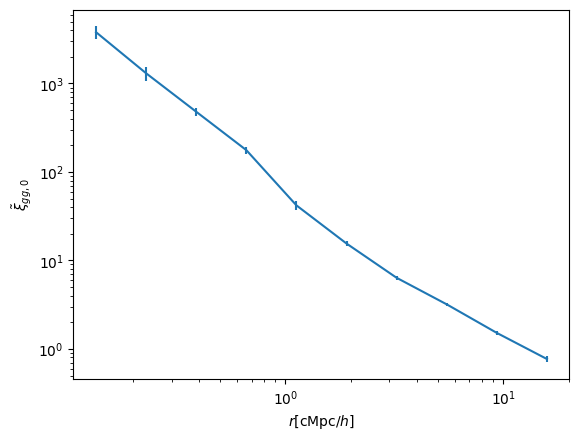

In [21]:
plt.figure()
plt.errorbar(IA_data.r,IA_data.multipoles_gg,yerr=IA_data.errors_multipoles_gg)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$\tilde{\xi}_{gg,0}$")
plt.xlabel(r"$r [\mathrm{cMpc}/h]$")
plt.show()

## Plot multipoles g+

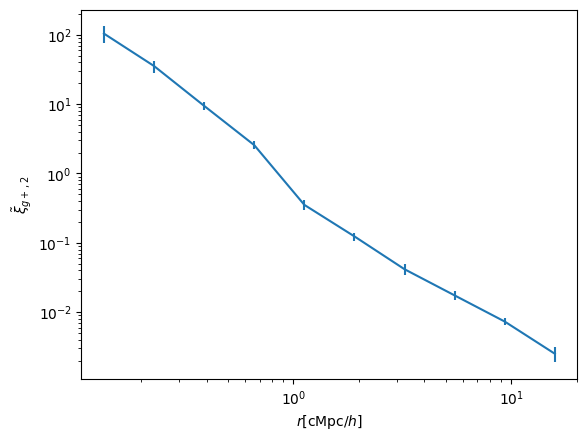

In [22]:
plt.figure()
plt.errorbar(IA_data.r,IA_data.multipoles_gp,yerr=IA_data.errors_multipoles_gp)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$\tilde{\xi}_{g+,2}$")
plt.xlabel(r"$r [\mathrm{cMpc}/h]$")
plt.show()